<a href="https://colab.research.google.com/github/dongs0104/UpliftModeling/blob/master/skeleton-day-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
import pandas as pd
link_hilstrom = 'https://drive.google.com/open?id=15osyN4c5z1pSo1JkxwL_N8bZTksRvQuU'
fluff, id = link_hilstrom.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Hillstrom.csv')
hillstrom_df = pd.read_csv('Hillstrom.csv')

In [0]:
import pandas as pd
link_ = 'https://drive.google.com/open?id=1b8N7WtwIe2WmQJD1KL5UAy70K13MxwKj'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Lalonde.csv')
lalonde_df = pd.read_csv('Lalonde.csv')

In [0]:
import csv
import json
import os
from os.path import isfile, join
from sklearn.model_selection import KFold, StratifiedKFold

def preprocess_data(df, dataset='hillstrom', verbose=True):
    """
    Preprocessing the dataset
     - Use one-hot encoding for categorical features
     - Check the name of the target variable and treatment variable
     - Drop the unused columns
     - Delete the unused data
    
    Args:
        df: A pandas.DataFrame which have all data of the dataset
        dataset: the name of the dataset
    Return:
        # I recommend to split into the dataframes of predictor variables, the 
        # target variable, and the treatment varaible
    """

    
    if dataset in ['hillstrom', 'email']:
    # For Hillstrom dataset, the ‘‘visit’’ target variable was selected
    #   as the target variable of interest and the selected treatment is 
    #   the e-mail campaign for women’s merchandise [1]
    # [1] Kane K, Lo VSY, Zheng J. True-lift modeling: Comparison of methods. 
    #    J Market Anal. 2014;2:218–238
        columns = df.columns
        for col in columns:
            if df[col].dtype != object:
                continue
            df = pd.concat(
                  [df, pd.get_dummies(df[col], 
                                      prefix=col, 
                                      drop_first=False)],
                  axis=1)
            df.drop([col], axis=1, inplace=True)

        df.columns = [col.replace('-', '').replace(' ', '_').lower()
                    for col in df.columns]
        df = df[df.segment_mens_email == 0]
        df.index = range(len(df))
        # 대상자 e-mail campaign for women’s merchandise
        # 불필요 정보 제거
        df.drop(['segment_mens_email', 
               'segment_no_email', 
               'conversion', 
               'spend'], axis=1, inplace=True)

        y_name = 'visit'
        t_name = 'segment_womens_email'
    else:
        raise NotImplementedError
    """  
    elif dataset in ['criteo', 'ad']:
    ###############################
    ###     Do it yourself!     ###
    ###############################
    elif dataset in ['lalonde', 'job']:
    ###############################
    ###     Do it yourself!     ###
    ###############################
    """

    
    df['Y'] = df[y_name]
    df.drop([y_name], axis=1, inplace=True)
    df['T'] = df[t_name]
    df.drop([t_name], axis=1, inplace=True)
    
    return df

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def performance(pr_y1_ct1, pr_y1_ct0, y, ct, groups=10):
    """
    1. Split the total customers into the given number of groups
    2. Calculate the statistics of each segment
    
    Args:
        pr_y1_ct1: the series (list) of the customer's expected return
        pr_y1_ct0: the expected return when a customer is not treated
        y: the observed return of customers
        ct: whther each customer is treated or not
        groups: the number of groups (segments). Should be 5, 10, or 20
    Return:
        DataFrame:
            columns:
                'n_y1_ct1': the number of treated responders
                'n_y1_ct0': the number of not treated responders
                'r_y1_ct1': the average return of treated customers
                'r_y1_ct0': the average return of not treated customers
                'n_ct1': the number of treated customers
                'n_ct0': the number of not treated customers
                'uplift': the average uplift (the average treatment effect)
            rows: the index of groups
    """
  
    ### check valid arguments
    if groups not in [5, 10, 20]:
        raise Exception("uplift: groups must be either 5, 10 or 20")
  
    ### check for NAs.
    if pr_y1_ct1.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_ct1")
    if pr_y1_ct0.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_ct0")
    if y.isnull().values.any():
        raise Exception("uplift: NA not permitted in y")
    if ct.isnull().values.any():
        raise Exception("uplift: NA not permitted in ct")
   
    ### check valid values for ct
    if set(ct) != {0, 1}:
        raise Exception("uplift: ct must be either 0 or 1")

    ### define dif_pred
    dif_pred = pr_y1_ct1 - pr_y1_ct0
  
    ### Make index same
    y.index = dif_pred.index
    ct.index = dif_pred.index
    
    mm = pd.DataFrame({
        'dif_pred': dif_pred,
        'y': y,
        't': ct,
        'dif_pred_r': dif_pred.rank(ascending=False, method='first')
    })

    mm_groupby = mm.groupby(pd.qcut(mm['dif_pred_r'], groups, labels=range(1, groups+1), duplicates='drop'))
  
    n_y1_t1 = mm_groupby.apply(lambda r: r[r['t'] == 1]['y'].sum())
    n_y1_t0 = mm_groupby.apply(lambda r: r[r['t'] == 0]['y'].sum())
    n_t1 = mm_groupby['t'].sum()
    n_t0 = mm_groupby['t'].count() - n_t1
  
    df = pd.DataFrame({
        'n_t1': n_t1,
        'n_t0': n_t0,
        'n_y1_t1': n_y1_t1,
        'n_y1_t0': n_y1_t0,
        'r_y1_t1': n_y1_t1 / n_t1,
        'r_y1_t0': n_y1_t0 / n_t0,
    })
    fillna_columns = ['n_y1_t1', 'n_y1_t0', 'n_t1', 'n_t0']
    df[fillna_columns] = df[fillna_columns].fillna(0)
    df.index.name = 'groups'

    df['uplift'] = df['r_y1_t1'] - df['r_y1_t0']
    df['uplift'] = round(df['uplift'], 6)

    return df


def qini(perf, plotit=True):
    nrow = len(perf)
    """
    Calculating the incremental gains (y-axis of Qini curve)
     - First, the cumulitative sum of the treated and the control groups are
      calculated with respect to the total population in each group at the
      specified decile
     - Afterwards we calculate the percentage of the total amount of people
      (both treatment and control) are present in each decile
    Args:
        perf: A return of the performance function (above)
        plotit: whether draw a plot or not
    Return:
        1. Qini value
        2. return or save the plot if plotit is True
    """
    cumul_y1_t1 = (perf['n_y1_t1'].cumsum() / perf['n_t1'].cumsum()).fillna(0)
    cumul_y1_t0 = (perf['n_y1_t0'].cumsum() / perf['n_t0'].cumsum()).fillna(0)
    deciles = [i/nrow for i in range(1, nrow+1)]

    ### Model Incremental gains
    inc_gains = (cumul_y1_t1 - cumul_y1_t0) * deciles
    inc_gains = [0.0] + list(inc_gains)

    ### Overall incremental gains
    overall_inc_gain = sum(perf['n_y1_t1']) / sum(perf['n_t1']) \
            - sum(perf['n_y1_t0']) / sum(perf['n_t0'])

    ### Random incremental gains
    random_inc_gains = [i*overall_inc_gain / nrow for i in range(nrow+1)]

    ### Compute area under the model incremental gains (uplift) curve
    x = [0] + deciles
    y = list(inc_gains)
    auuc = 0
    auuc_rand = 0

    auuc_list = [auuc]
    for i in range(1, len(x)):
        #면적
        auuc += 0.5 * (x[i] - x[i-1]) * (y[i] + y[i-1])
        auuc_list.append(auuc)

    ### Compute area under the random incremental gains curve
    y_rand = random_inc_gains

    auuc_rand_list = [auuc_rand]
    for i in range(1, len(x)):
        auuc_rand += 0.5 * (x[i] - x[i-1]) * (y_rand[i] + y_rand[i-1])
        auuc_rand_list.append(auuc_rand)

    ### Compute the difference between the areas (Qini coefficient)
    Qini = auuc - auuc_rand

    ### Plot incremental gains curve
    if plotit:
        x_axis = x
        plt.plot(x_axis, inc_gains)
        plt.plot(x_axis, random_inc_gains)
        plt.show()
    
    ### Qini 30%, Qini 10%
    n_30p = int(nrow*3/10)
    n_10p = int(nrow/10)
    qini_30p = auuc_list[n_30p] - auuc_rand_list[n_30p]
    qini_10p = auuc_list[n_10p] - auuc_rand_list[n_10p]

    res = {
        'qini': Qini,
        'inc_gains': inc_gains,
        'random_inc_gains': random_inc_gains,
        'auuc_list': auuc_list,
        'auuc_rand_list': auuc_rand_list,
        'qini_30p': qini_30p,
        'qini_10p': qini_10p,
    }    

    return res


In [0]:
import itertools
import numpy as np


def parameter_tuning(fit_mdl, pred_mdl, data, search_space):
    """
    Given a model, search all combination of parameter sets and find
    the best parameter set
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "ct_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "ct_test": treatment variables of test (usually, validation) dataset,
            }
        search_space:
            {
                parameter_name: [search values]
            }
    Return:
        The best parameter set
    """
    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']
    
    max_q = -float('inf')
    best_mdl = None

    keys = search_space.keys()
    n_space = [len(search_space[key]) for key in keys]
    n_iter = np.prod(n_space)
    
    best_params = None
    for i in range(n_iter):
        params = {}
        for idx, key in enumerate(keys):
            params[key] = search_space[key][i % n_space[idx]]
            i = int(i / n_space[idx])

        mdl = fit_mdl(x_train, y_train, t_train, **params)
        pred = pred_mdl(mdl, newdata=x_test, y=y_test, ct=t_test)
        # print('    {}'.format(params))
        try:
            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        except Exception as e:
            print(e)
            continue
        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            best_mdl = mdl
            best_params = params

    return best_mdl, best_params

  
def wrapper(fit_mdl, pred_mdl, data, params=None,
            best_models=None, drop_variables=None, qini_values=None):
    """
    General wrapper approach
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "ct_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "ct_test": treatment variables of test (usually, validation) dataset,
            }
    Return:
        (A list of best models, The list of dropped variables)
    """
    if best_models is None:
        best_models = []
    if drop_variables is None:
        drop_variables = []
    if qini_values is None:
        qini_values = []
    if params is None:
        params = {}

    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']
                        
    variables = data['x_train'].columns

    max_q = -float('inf')
    drop_var = None
    best_mdl = None
    for var in variables:
        if var in drop_variables:
            continue
        x = x_train.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        mdl = fit_mdl(x, y_train, t_train, **params)
        x = x_test.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        pred = pred_mdl(mdl, newdata=x, y=y_test, ct=t_test)
        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            drop_var = var
            best_mdl = mdl
    
    best_models.append(best_mdl)
    drop_variables.append(drop_var)
    qini_values.append(max_q)
                        
    left_vars = [var for var in variables if (var not in drop_variables)]

    if len(variables) == len(drop_variables) + 1:
        return best_models, drop_variables + left_vars, qini_values
    else:
        return wrapper(fit_mdl, pred_mdl, data, params=params,
                       best_models=best_models, drop_variables=drop_variables,
                       qini_values=qini_values)


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def tma(x, y, ct, method=LogisticRegression, **kwargs):
    """Training a model according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    The default model is General Linear Model (GLM)
    
    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        ct: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        Dictionary: A dictionary of two models. One for the treatment group, 
            one for the control group.

            {
                'model_treat': a model for the treatment group,
                'model_control': a model for the control group
            }

    """
    treat_rows = (ct == 1)
    control_rows = (ct == 0)
    model_treat = method(**kwargs).fit(x[treat_rows], y[treat_rows])
    model_control = method(**kwargs).fit(x[control_rows], y[control_rows])
    
    return {'model_treat':model_treat, 'model_control':model_control}


def predict_tma(obj, newdata, **kwargs):
    """Predictions according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    
    For each instance in newdata two predictions are made:
    1) What is the probability of a person responding when treated?
    2) What is the probability of a person responding when not treated
      (i.e. part of control group)?

    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        obj: A dictionary of two models. 
            One for the treatment group, one for the control group.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        DataFrame: A dataframe with predicted returns for when the customers
            are treated and for when they are not treated.
    """
   
    if isinstance(obj['model_treat'], LinearRegression):
        pred_treat = obj['model_treat'].predict(newdata)
    else:
        pred_treat = obj['model_treat'].predict_proba(newdata)[:, 1]

    if isinstance(obj['model_control'], LinearRegression):
        pred_control = obj['model_control'].predict(newdata)
    else:
        pred_control = obj['model_control'].predict_proba(newdata)[:, 1]
    
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df



In [0]:
import sys
import math

class Node(object):
    def __init__(self, attribute, threshold):
        self.attr = attribute
        self.thres = threshold
        self.left = None
        self.right = None
        self.leaf = False
        self.predict = None


def select_threshold(df, attribute, predict_attr):
    """
    Select the threshold of the attribute to split
    The threshold chosen splits the test data such that information gain is maximized
    """
    # Convert dataframe column to a list and round each value
    values = df[attribute].tolist()
    values = [float(x) for x in values]
    # Remove duplicate values by converting the list to a set, then sort the set
    values = set(values)
    values = list(values)
    values.sort()
    max_ig = float("-inf")
    thres_val = 0
    # try all threshold values that are half-way between successive values in this sorted list
    for i in range(0, len(values) - 1):
        thres = (values[i] + values[i+1])/2
        ig = info_gain(df, attribute, predict_attr, thres)
        if ig > max_ig:
            max_ig = ig
            thres_val = thres
    # Return the threshold value that maximizes information gained
    return thres_val


def info_entropy(df, predict_attr):
    """
    Calculate info content (entropy) of the test data
    """
    # Dataframe and number of positive/negatives examples in the data
    p_df = df[df[predict_attr] == 1]
    n_df = df[df[predict_attr] == 0]
    p = float(p_df.shape[0])
    n = float(n_df.shape[0])
    # Calculate entropy
    if p  == 0 or n == 0:
        I = 0
    else:
        I = ((-1*p)/(p + n))*math.log(p/(p+n), 2) + ((-1*n)/(p + n))*math.log(n/(p+n), 2)
    return I


def remainder(df, df_subsets, predict_attr):
    """
    Calculates the weighted average of the entropy after an attribute test
    """
    # number of test data
    num_data = df.shape[0]
    remainder = float(0)
    for df_sub in df_subsets:
        if df_sub.shape[0] > 1:
            remainder += float(df_sub.shape[0]/num_data)*info_entropy(df_sub, predict_attr)
    return remainder


def info_gain(df, attribute, predict_attr, threshold):
    """
    Calculates the information gain from the attribute test based on a given threshold
    Note: thresholds can change for the same attribute over time
    """
    sub_1 = df[df[attribute] <= threshold]
    sub_2 = df[df[attribute] > threshold]
    # Determine information content, and subract remainder of attributes from it
    ig = info_entropy(df, predict_attr) - remainder(df, [sub_1, sub_2], predict_attr)
    return ig


def num_class(df, predict_attr):
    """
    Returns the number of positive and negative data
    """
    p_df = df[df[predict_attr] == 1]
    n_df = df[df[predict_attr] == 0]
    return p_df.shape[0], n_df.shape[0]


def choose_attr(df, attributes, predict_attr):
    """
    Chooses the attribute and its threshold with the highest info gain
    from the set of attributes
    """
    max_info_gain = float("-inf")
    best_attr = None
    threshold = 0
    # Test each attribute (note attributes maybe be chosen more than once)
    for attr in attributes:
        thres = select_threshold(df, attr, predict_attr)
        ig = info_gain(df, attr, predict_attr, thres)
        if ig > max_info_gain:
            max_info_gain = ig
            best_attr = attr
            threshold = thres
    return best_attr, threshold



def build_tree(df, cols, predict_attr):
    """
    Builds the Decision Tree based on training data, attributes to train on,
    and a prediction attribute
    """
    # Get the number of positive and negative examples in the training data
    p, n = num_class(df, predict_attr)
    # If train data has all positive or all negative values or less than the
    # given minimum number of split. Then we have reached the end of our tree
    if p == 0 or n == 0 or (p+n) < 100:
        # Create a leaf node indicating it's prediction
        leaf = Node(None,None)
        leaf.leaf = True
        leaf.predict = p / (p+n)
        return leaf
    else:
        # Determine attribute and its threshold value with the highest
        # information gain
        best_attr, threshold = choose_attr(df, cols, predict_attr)
        # Create internal tree node based on attribute and it's threshold
        tree = Node(best_attr, threshold)
        sub_1 = df[df[best_attr] <= threshold]
        sub_2 = df[df[best_attr] > threshold]
        # Recursively build left and right subtree
        tree.left = build_tree(sub_1, cols, predict_attr)
        tree.right = build_tree(sub_2, cols, predict_attr)
        return tree


def predict(node, row_df):
    """
    Given a instance of a training data, make a prediction of an observation (row)
    based on the Decision Tree
    Assumes all data has been cleaned (i.e. no NULL data)
    """
    # If we are at a leaf node, return the prediction of the leaf node
    if node.leaf:
        return node.predict
    # Traverse left or right subtree based on instance's data
    if row_df[node.attr] <= node.thres:
        return predict(node.left, row_df)
    elif row_df[node.attr] > node.thres:
        return predict(node.right, row_df)


def test_predictions(root, df, target_attr='Y'):
    """
    Given a set of data, make a prediction for each instance using the Decision Tree
    """
    prediction = []
    for index,row in df.iterrows():
        prediction.append(predict(root, row))
    pred_df = pd.Series(prediction)
    return pred_df

In [0]:
def ty_assign(y, t):
    if y == 1 and t == 1:
        return "TR"
    elif y == 0 and t == 1:
        return "TN"
    elif y == 1 and t == 0:
        return "CR"
    elif y == 0 and t == 0:
        return "CN"
    else:
        return None
    
def ct_y_assign(y, ct):
    if y == 1 and ct == 1:
        return "TR"
    elif y == 0 and ct == 1:
        return "TN"
    elif y == 1 and ct == 0:
        return "CR"
    elif y == 0 and ct == 0:
        return "CN"
    else:
        return None


def y_assign(ct_y):
    if ct_y in ("TR", "TN"):
        return 1
    elif ct_y in ("CR", "CN"):
        return 0
    else:
        return None


def ct_assign(ct_y):
    if ct_y in ("TR", "CR"):
        return 1
    elif ct_y in ("TN", "CN"):
        return 0
    else:
        return None

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


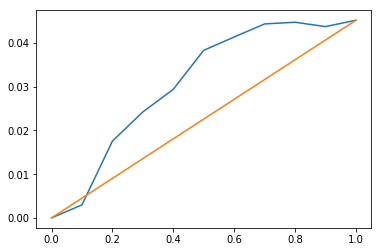

         n_t1   n_t0  n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0    uplift
groups                                                              
1       408.0  446.0       68       61  0.166667  0.136771  0.029895
2       427.0  427.0      100       38  0.234192  0.088993  0.145199
3       438.0  416.0       79       47  0.180365  0.112981  0.067385
4       413.0  441.0       65       47  0.157385  0.106576  0.050809
5       433.0  421.0       74       34  0.170901  0.080760  0.090141
6       448.0  406.0       65       46  0.145089  0.113300  0.031789
7       409.0  445.0       26       18  0.063570  0.040449  0.023120
8       424.0  430.0       41       40  0.096698  0.093023  0.003675
9       444.0  410.0       49       49  0.110360  0.119512 -0.009152
10      434.0  420.0       81       73  0.186636  0.173810  0.012826
Qini values:  [0.008331966838155482]
    mean: 0.008331966838155482, std: 0.0


In [0]:

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

import pandas as pd

dataset='hillstrom'

search_space = { 
    'method': [LogisticRegression],
    'solver': ['newton-cg','libfgs','sag','saga'],
    'pernalty':['none','l2'],
    'tol': [1e-2, 1e-3, 1e-4],
    'C': [1e6,1e3,1e-3,1e-6]
}

def main():
    ### Load data ###
    hdf = preprocess_data(hillstrom_df)
    models = [LogisticRegression]
    for model in models:
        x = hdf.drop(columns=['Y','T'], axis=1)
        Y = hdf['Y']
        T = hdf['T']
        ct_y = pd.DataFrame({'Y': Y, 'T': T})\
             .apply(lambda row: ct_y_assign(row['Y'], row['T']), axis=1)
        fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(x, ct_y)
        ### Cross validation ###
        qini_list = []
        for idx, (train_index, test_index) in enumerate(fold_gen):
            x_train = x.reindex(train_index)
            x_test = x.reindex(test_index)
            y_train = Y.reindex(train_index)
            y_test = Y.reindex(test_index)
            ct_train = T.reindex(train_index)
            ct_test = T.reindex(test_index)
            
            df = x_train.copy()
            df['Y'] = y_train
            df['T'] = ct_train
            stratify = ct_train
            if dataset == 'hillstrom':
                stratify = df[['Y', 'T']]
            tuning_df, validate_df = train_test_split(
                df, test_size=0.33, random_state=1234, stratify=stratify)
            x_tuning = tuning_df.drop(['Y', 'T'], axis=1)
            y_tuning = tuning_df['Y']
            t_tuning = tuning_df['T']

            x_validate = validate_df.drop(['Y', 'T'], axis=1)
            y_validate = validate_df['Y']
            t_validate = validate_df['T']

            data_dict = {
                "x_train": x_tuning,
                "y_train": y_tuning,
                "t_train": t_tuning,
                "x_test": x_validate,
                "y_test": y_validate,
                "t_test": t_validate,
            }
            model_method = search_space.get('method', None)
            params = {
                'method': None if model_method is None else model_method[0],
            }
            if params['method'] == LogisticRegression:
                solver = search_space.get('solver', None)
                params['solver'] = None if solver is None else solver[0]
                
            #_, drop_vars, qini_values = wrapper(
            #    tma, predict_tma, data_dict, params=params)
            #best_qini = max(qini_values)
            #best_idx = qini_values.index(best_qini)
            #best_drop_vars = drop_vars[:best_idx]
            
        ### Parameter tuning ###
            #_, best_params = parameter_tuning(tma, predict_tma, data_dict, 
            #                              search_space=search_space)
            
            tm = tma(x_train, y_train, ct_train)
            pred = predict_tma(obj=tm, newdata=x_test)
            perf = performance(pred['pr_y1_t1'],pred['pr_y1_t0'],y_test,ct_test)
            q = qini(perf)
            print(perf)
            qini_list.append(q['qini'])
            print('Qini values: ', qini_list)
            print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
            
            df_train = x_train.copy()
            df_train['Y'] = y_train
            df_train['T'] = ct_train
            df_test = x_test.copy()
            df_test['Y'] = y_test
            df_test['T'] = ct_test
            df_train.drop(['history'], axis=1, inplace=True)
            df_test.drop(['history'], axis=1, inplace=True)

            assert((df_train.columns == df_test.columns).all())
            attributes = [c for c in df_train.columns if c != 'Y']
            
            root = build_tree(df_train, attributes, 'Y')
            pred = test_predictions(root, df_test, target_attr='Y')
            #print('pred: {}'.format(pred))
#         print("Model: {}\n".format(model))
#         print("Tuning space: \n")
#         for key, val in search_space.items():
#             print("    '{}': {}\n".format(key, val))
#         print("Seed: {}\n".format(seed))
#         print("Qini value: mean = {}, std = {}\n\n".format(mean_qini, std_qini))
main()